In [97]:
import numpy as np
from activation_helper import sigmoid, relu
from make_dataset_helper import prepare_dataset
import logging
import math
import matplotlib.pyplot as plt
% matplotlib inline


np.random.seed(0)

In [98]:
def forward_function(prev_A, W, b, activation):
    Z = np.dot(W, prev_A) + b
    
    if activation == "sigmoid":
        A = sigmoid(Z)    
    elif activation == "tanh":
        A = np.tanh(Z)
        
    elif activation == "relu":
        A = relu(Z)
    
    #test done
    return Z, A

In [99]:
def l_layer_forward(X, parameters, layer_dims, keep_probs, activation):
    layer_num = len(layer_dims)
    outputs = {}
    dropouts = {}
    outputs["A0"] = X
    for i in range(1, layer_num):
        prev_A = outputs["A" + str(i - 1)]
        W = parameters["W" + str(i)]
        b = parameters["b" + str(i)]
        if i == layer_num - 1:
            activation = "sigmoid"
        Z, A = forward_function(prev_A, W, b, activation)
        
        D = np.random.rand(A.shape[0], A.shape[1])
        D = (D <  keep_probs)
        A = D * A
        A = A / keep_probs
        outputs["Z" + str(i)], outputs["A" + str(i)] = Z, A
        dropouts["D" + str(i)] = D
        
        assert(outputs["Z" + str(i)].shape == outputs["A" + str(i)].shape)
        assert(outputs["Z" + str(i)].shape == (layer_dims[i], X.shape[1]))
    
    # test done
    return outputs, dropouts

In [100]:
def caluculate_cost(AL, y, m, lambd, parameters):
    numW = len(parameters) // 2
    squared_sumlistW = np.array([])
    for i in range(1, numW + 1):
        squared_sumlistW = np.append(squared_sumlistW, np.sum(parameters["W" + str(i)] ** 2))
    cost = - 1 / m * (np.dot(y, np.log(AL.T)) + np.dot((1 - y), np.log(1 - AL).T)) + (1/m) * (lambd / 2) * (np.sum(squared_sumlistW))
    return np.squeeze(cost)

In [101]:
def l_layer_backward(parameters, outputs, grads, layer_dims, y, m, lambd, dropouts, keep_probs, activation) -> dict:
    layer_num = len(layer_dims)
    AL = outputs["A" + str(layer_num - 1)]
    grads["dA" + str(layer_num - 1)] = -(y / AL) + (1 - y) / (1 - AL)
    for i in reversed(range(1, layer_num)):
        Z, A = outputs["Z" + str(i)], outputs["A" + str(i)]
        prev_A = outputs["A" + str(i - 1)]
        W = parameters["W" + str(i)]
        dA = grads["dA" + str(i)]
        D  = dropouts["D" + str(i)]
        dA = dA * D
        dA = dA / keep_probs
        if i == layer_num -1:
            activation_f = "sigmoid"
        else:
            activation_f = activation
            
        dZ, dW, db, dprev_A = backward_function(dA, Z, A, prev_A, W, m, lambd, activation_f)
        grads["dW" + str(i)], grads["db" + str(i)], grads["dA" + str(i - 1)] = dW, db, dprev_A
        assert(Z.shape == dZ.shape)
        assert(W.shape == dW.shape)
        
    return grads 

In [102]:
def backward_function(dA, Z, A, prev_A, W, m, lambd, activation):
    if activation == "sigmoid":
        dZ = dA * A * (1 - A)
        
    elif activation == "tanh":
        dZ = dA * (1 - A ** 2)
        
    elif activation == "relu":
        temp = (Z > 0)
        dZ = dA * temp
        
    dW = 1 / m * np.dot(dZ, prev_A.T) + lambd / m * W
    db = 1/ m * np.sum(dZ, axis=1, keepdims=True)
    dprev_A = np.dot(W.T, dZ)
    return dZ, dW, db, dprev_A

In [103]:
def initialize_parameter(layer_dims: list, initialize: str) -> dict:
    # generate parameter W, b
    parameters = {}
    for i in range(1, len(layer_dims)):
        if initialize == "random":
            parameters["W" + str(i)] = np.random.randn(layer_dims[i], layer_dims[i - 1]) * 0.01
        elif initialize == "he":
            parameters["W" + str(i)] = np.random.randn(layer_dims[i], layer_dims[i-1]) * np.sqrt(2 / layer_dims[i - 1])
            
        parameters["b" + str(i)] = np.zeros((layer_dims[i], 1))
    
    assert(parameters["W1"].shape == (layer_dims[1], layer_dims[0]))
    
    # test done
    return parameters


In [203]:
def update_parameters(parameters, grads, layer_dims, learning_rate0, learning_rate_decay, iteration_i, optimize, v, S):
    
    if learning_rate_decay:
        learning_rate = (0.99999999 ** iteration_i) * learning_rate0
        
    beta1 = 0.9
    beta2 = 0.9
    epsilon = 0.0001
        
    if optimize=="gd":
        for i in range(1, len(layer_dims)):
            parameters["W" + str(i)] -= learning_rate * grads["dW" + str(i)]
            parameters["b" + str(i)] -= learning_rate * grads["db" + str(i)]
            
    elif optimize == "momentum":
        for i in range(1, len(layer_dims)):
            v["dW" + str(i)] = beta1 * v["dW" + str(i)] + (1 - beta1) * grads["dW" + str(i)]
            v["db" + str(i)] = beta1 * v["db" + str(i)] + (1 - beta1) * grads["db"+ str(i)]
            parameters["W" + str(i)] -= learning_rate * v["dW" + str(i)]
            parameters["b" + str(i)] -= learning_rate * v["db" + str(i)]
            
    elif optimize == "rmsprop":
        for i in range(1, len(layer_dims)):
            S["dW" + str(i)] = beta2 * S["dW" + str(i)] + (1 - beta2) * grads["dW" + str(i)]**2
            S["db" + str(i)] = beta2 * S["db" + str(i)] + (1 - beta2) * grads["db"+ str(i)]**2
            parameters["W" + str(i)] -= learning_rate * grads["dW" + str(i)] / np.sqrt(S["dW" + str(i)] + epsilon)
            parameters["b" + str(i)] -= learning_rate * S["db" + str(i)] / np.sqrt(S["db" + str(i)] + epsilon)
        
    elif optimize == "adam":
        for i in range(1, len(layer_dims)):
            v["dW" + str(i)] = beta1 * v["dW" + str(i)] + (1 - beta1) * grads["dW" + str(i)]
            v["db" + str(i)] = beta1 * v["db" + str(i)] + (1 - beta1) * grads["db"+ str(i)]
            S["dW" + str(i)] = beta2 * S["dW" + str(i)] + (1 - beta2) * grads["dW" + str(i)]**2
            S["db" + str(i)] = beta2 * S["db" + str(i)] + (1 - beta2) * grads["db"+ str(i)]**2
            
            # adjust the scale of each values
            vdW_correction = v["dW" + str(i)] / (1 - beta1 ** iteration_i)
            vdb_correction = v["db" + str(i)] / (1 - beta1 ** iteration_i)
            SdW_correction = S["dW" + str(i)] / (1 - beta2 ** iteration_i)
            Sdb_correction = S["db" + str(i)] / (1 - beta2 ** iteration_i)
            
            parameters["W" + str(i)] -= learning_rate * vdW_correction / np.sqrt(SdW_correction + epsilon) 
            parameters["b" + str(i)] -= learning_rate * vdb_correction / np.sqrt(Sdb_correction + epsilon)
            

    return parameters

In [204]:
def initialize_for_momentum(parameters, optimize):
    optimize_for_momentums = {}
    if optimize == "gd" or optimize == "rmsprop":
        pass
    
    elif optimize == "momentum" or optimize == "adam":
        for key in parameters.keys():
            optimize_for_momentums["d" + str(key)] = np.zeros(parameters[key].shape)
    
    
    return optimize_for_momentums
    

In [205]:
def initialize_for_rmsprop(parameters, optimize):
    optimize_for_rmsprops = {}
    if optimize == "sgd" or optimize == "momentum":
        pass
    elif optimize == "rmsprop" or optimize == "adam":
        for key in parameters.keys():
            optimize_for_rmsprops["d" + str(key)] = np.zeros(parameters[key].shape)
            
    return optimize_for_rmsprops
        

In [206]:
def main(X, y, layer_dims, logger, learning_rate=0.01, iteration_num=1000, lambd=0,keep_probs=1, \
         activation="relu", initialize="random", minibatch_size=None, learning_rate_decay=False, \
        optimize="gd"):
    # main function
    # valuable 
    # parameters - contain W and b on each layer as dictionary like "W1"
    # outputs - coutain Z and A on each layer as dictionary like "A1"
    if minibatch_size==None:
        minibatch_size = X.shape[1]
    
#     generate_minibatch(X, y, minibatch_size)
    minibatch_num = math.ceil(X.shape[1] / minibatch_size)
    logger.debug(minibatch_num)
    
    
    
    parameters = initialize_parameter(layer_dims, initialize)
    
    optimize_for_momentums = initialize_for_momentum(parameters, optimize)
    
    optimize_for_rmsprops = initialize_for_rmsprop(parameters, optimize)
        
    str_AL = "A" + str(len(layer_dims) - 1)
    costs = np.array([])
    for i in range(iteration_num):
        partition = list(np.random.permutation(X.shape[1]))
        X = X[:, partition]
        y = y[:, partition]
        for k in range(minibatch_num):
            if k == minibatch_num - 1:
                # final minibatch
                X_shuffle = X[:, k * minibatch_size:]
                y_shuffle = y[:, k* minibatch_size:]
            else:
                X_shuffle = X[:, k * minibatch_size: (k + 1) * minibatch_size]
                y_shuffle = y[:, k * minibatch_size: (k + 1) * minibatch_size]
            m = X_shuffle.shape[1]
            outputs, dropouts = l_layer_forward(X_shuffle, parameters, layer_dims, keep_probs, activation)
            cost=caluculate_cost(outputs[str_AL],y_shuffle,m,lambd,parameters)
        
            grads = {}
            grads = l_layer_backward(parameters, outputs, grads, layer_dims, y_shuffle, m, lambd, dropouts, keep_probs, activation)
        
            parameters = update_parameters(parameters, grads, layer_dims, learning_rate, learning_rate_decay, i, optimize, optimize_for_momentums, optimize_for_rmsprops)
        
        costs = np.append(costs, cost)
        
        if i % 100 == 0:
            logger.info(cost)
            
    plt.title("Cost Function")
    plt.scatter(x=range(iteration_num),y=costs)
    
    return parameters

In [207]:
def predict(X, parameters, layer_dims, keep_probs=1, activation="tanh"):
    outputs= l_layer_forward(X, parameters, layer_dims, keep_probs, activation)[0]
    layer_num = len(layer_dims)
    AL = "A" + str(layer_num - 1)
    y_hat = outputs[AL]
    func = lambda x: 0 if x <= 0.5 else 1
    vfunc = np.vectorize(func)
    y_hat = vfunc(y_hat)
    return y_hat

In [208]:
def caluculate_score(y, y_hat) -> int:
    assert(y.shape == y_hat.shape)
    score = np.sum(y == y_hat) / y.shape[1]
    return score

INFO:root:train accuracy
DEBUG:root:1
/Users/shumpei/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:37: RuntimeWarning: divide by zero encountered in true_divide
/Users/shumpei/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:38: RuntimeWarning: divide by zero encountered in true_divide
/Users/shumpei/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:38: RuntimeWarning: invalid value encountered in true_divide
/Users/shumpei/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in true_divide
/Users/shumpei/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:40: RuntimeWarning: divide by zero encountered in true_divide
/Users/shumpei/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in true_divide
/Users/shumpei/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in true_divide
/Users/shumpe

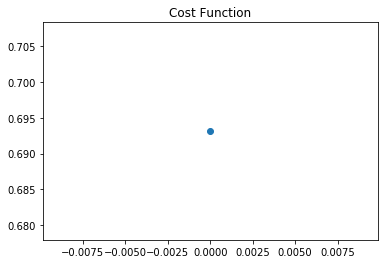

In [209]:
if __name__ == '__main__':
    logger = logging.getLogger()
    logging.basicConfig(level="DEBUG")
    X_train, X_test, y_train, y_test = prepare_dataset()
    layer_dims=[X_train.shape[0],3,1]
    logger.info("train accuracy")
    parameters = main(X_train, y_train, layer_dims,logger, learning_rate=0.01, iteration_num=1000, \
                      lambd=0.5, keep_probs=1, learning_rate_decay=True, optimize="adam")
    y_train_hat = predict(X_train, parameters, layer_dims, keep_probs=1, activation="relu") #
    logger.info("train accuracy {}".format(caluculate_score(y_train, y_train_hat)))
    y_test_hat = predict(X_test, parameters, layer_dims, keep_probs=1)
    logger.info("test accuracy {}".format(caluculate_score(y_test, y_test_hat)))
    